## Brain network application

In [1]:
import numpy as np
import pandas as pd
import math as m
import random as r
import cvxpy as cp
from scipy.integrate import odeint
import seaborn as sns
import KuramotoFunctionBank as KFB
import GPMAlgorithm as GPM
import importlib
import matplotlib.pyplot as plt
import csv
import cmath
from scipy.signal import butter, lfilter, hilbert
importlib.reload(KFB)
importlib.reload(GPM)

<module 'GPMAlgorithm' from '/Users/Moncho/Desktop/Year 1/kuramotocontrol/GPMAlgorithm.py'>

In [2]:
subnetwork = [22, 17, 20, 23, 19, 10, 43, 48, 45, 42, 46, 55]
N=12
Subj18Run2 = open('Subject18Run2.txt', 'r')
permutation = open('permutation.txt','r')
reader = csv.reader(Subj18Run2)
reader2 = csv.reader(permutation)
DataAsList = [row for row in reader]
permutation = [x-1 for x in list(map(int, [row.split(',') for row in permutation][0]))]
DataAsArray =[]
for data in DataAsList:
    DataAsArray.append(data[0].split(' '))
for i in range(0,len(DataAsArray)):
    while '' in DataAsArray[i]:
        DataAsArray[i].remove('')
    for j in range(0,len(DataAsArray[i])):
        DataAsArray[i][j]=float(DataAsArray[i][j])
DataAsArray=np.array(DataAsArray)
#Phase-locked region is the same as the one obtained by Basset et al.
#Permute according to parcellation
DataAsArray=DataAsArray[:,permutation]
#Filter using same parameters as Basset 
FilteredSignals = KFB.butter_bandpass_filter(DataAsArray,0.04,0.06,0.5,10)
FilteredSignals = FilteredSignals[248:268,subnetwork]

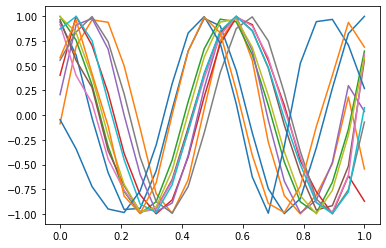

In [3]:
analytic_signal = hilbert(FilteredSignals,axis=0)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
t=np.linspace(0,1,20)
for i in range(0,N):
    ax = sns.lineplot(t,np.sin(instantaneous_phase[:,i]))
instantaneous_phase_no_mod = KFB.RemoveBounds(instantaneous_phase)

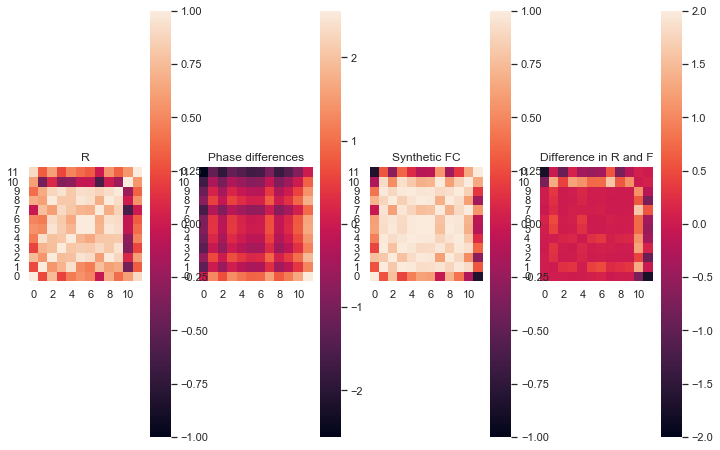

In [67]:
Cos_Phase_Differences = np.zeros((N,N,20))
Phase_Differences = np.zeros((N,N,20))
for i in range(0,20):
    for j in range(0,N):
        for k in range(0,N):
            Cos_Phase_Differences[j][k][i] = np.cos(instantaneous_phase[i][k]-instantaneous_phase[i][j])
            Phase_Differences[j][k][i] = instantaneous_phase[i][k]-instantaneous_phase[i][j]
Average_Cos_Phase_Difference = np.mean(Cos_Phase_Differences,axis=2)
Average_Phase_Difference = np.mean(Phase_Differences,axis=2)
C = KFB.CalculateCFromMeanPhaseDiff(Average_Phase_Difference)
EstimatedPhases = GPM.GPMAlgorithm(C)
x_min_brain = KFB.CalculateXMinFromPhases(EstimatedPhases)
SyntheticFC = KFB.CalculateCorrelationMatrix(x_min_brain)
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4)
ax1= sns.heatmap(Average_Cos_Phase_Difference.T,ax=ax1,square=True,vmin=-1,vmax=1)
ax1.invert_yaxis()
ax2= sns.heatmap(Average_Phase_Difference.T,ax=ax2,square=True)
ax2.invert_yaxis()
ax3= sns.heatmap(SyntheticFC.T,ax=ax3,square=True,vmin=-1,vmax=1)
ax3.invert_yaxis()
ax4= sns.heatmap(SyntheticFC.T-Average_Cos_Phase_Difference.T,ax=ax4,square=True,vmin=-2,vmax=2)
ax4.invert_yaxis()
ax1.title.set_text('R')
ax2.title.set_text('Phase differences')
ax3.title.set_text('Synthetic FC')
ax4.title.set_text('Difference in R and F')
plt.show()

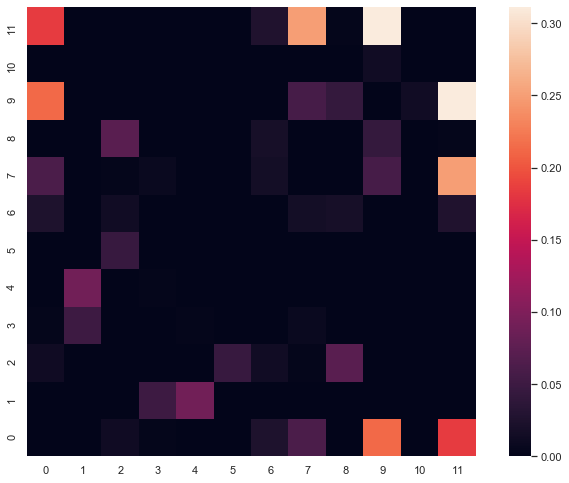

In [5]:
SC_DF = pd.read_csv('StructuralConnectivity.csv',header=None)
SCMatrix = np.array(SC_DF)
#Remove Diagonals
SC = SCMatrix[subnetwork,:]
SC = SC[:,subnetwork]
SC = SC - np.diagflat(np.diag(SC))
SC = (SC+SC.T)/2
ax = sns.heatmap(SC.T,square=True)
ax.invert_yaxis()
#Calculate quantities from inital parameters 
edges = KFB.CalculateEdgeSet(SC)
x_desired = KFB.CalculatePhaseDifferencesFromMin(x_min_brain,edges)
D = KFB.CalculateSinMatrix(edges,x_desired)
B = KFB.CalculateIncidenceMatrix(edges,N)
B_D = np.matmul(B,D)
delta1 = KFB.CalculateDeltaFromAdj(SC,edges)

w=B_D@delta1

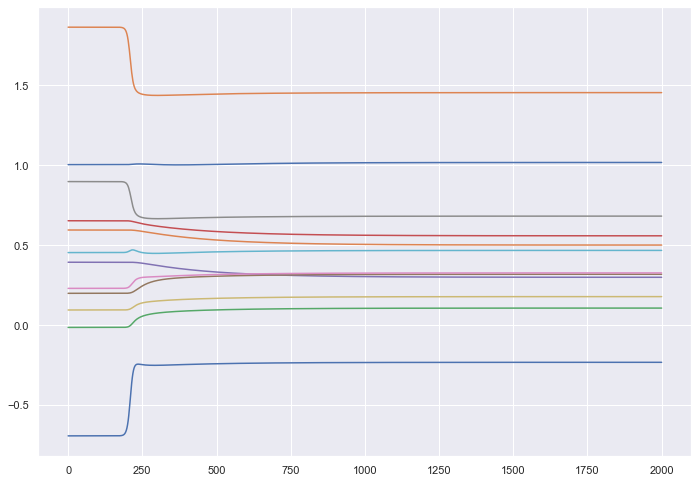

In [79]:
#Calculate quantities from inital parameters 
edges = KFB.CalculateEdgeSet(SC)
x_desired = KFB.CalculatePhaseDifferencesFromMin(x_min_brain,edges)
D = KFB.CalculateSinMatrix(edges,x_desired)
B = KFB.CalculateIncidenceMatrix(edges,N)
B_D = np.matmul(B,D)
delta1 = KFB.CalculateDeltaFromAdj(SC,edges)
w=B_D@delta1

#Solving the model with these params
theta_0 = EstimatedPhases
T=2000
num_points = 1000

sol,t = KFB.SolveKuramotoModel(theta_0,T,N,w,SC,num_points)

#Plot oscillator trajcetories
for i in range(0,N):
    ax = sns.lineplot(x=t,y=sol[:,i])

rho = np.zeros((N,N))
for i in range(0,N):
    for j in range(i+1,N):
        rho[i,j]=np.mean(np.cos(sol[:,j]-sol[:,i]))
rho = rho + rho.T + np.identity(N)

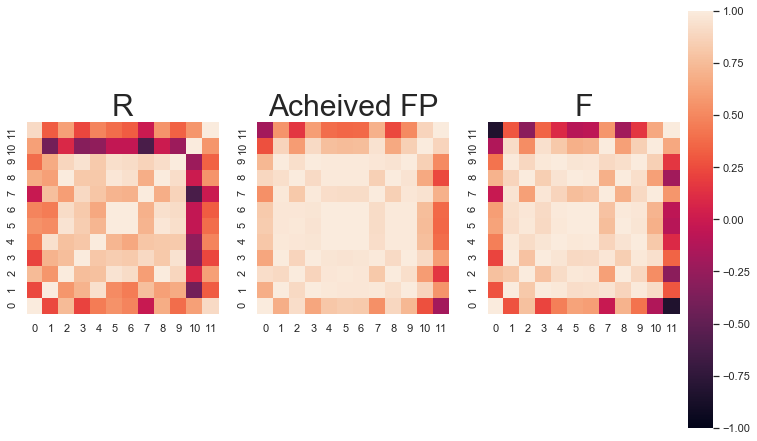

In [80]:
#Plot the acheived functional pattern to compare to the desired functional pattern
x_acheived = KFB.CalculatePhaseDiffs(sol[num_points-1,:])
Rho_desired = KFB.CalculateCorrelationMatrix(x_min_brain)
Rho_acheived = KFB.CalculateCorrelationMatrix(x_acheived)
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.title.set_text('R')
ax1.title.set_size(30)
ax2.title.set_text('Acheived FP')
ax2.title.set_size(30)
ax3.title.set_text('F')
ax3.title.set_size(30)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
sns.heatmap(Average_Cos_Phase_Difference.T, ax=ax1,square=True,cbar_ax=cbar_ax,vmin=-1,vmax=1)
sns.heatmap(rho.T, ax=ax2,square = True,cbar_ax=cbar_ax,vmin=-1,vmax=1)
sns.heatmap(SyntheticFC.T, ax=ax3,square=True,cbar_ax=cbar_ax,vmin=-1,vmax=1)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
plt.show()

## Full parcellation

In [85]:
N=66
Subj18Run2 = open('Subject18Run2.txt', 'r')
permutation = open('permutation.txt','r')
reader = csv.reader(Subj18Run2)
reader2 = csv.reader(permutation)
DataAsList = [row for row in reader]
permutation = [x-1 for x in list(map(int, [row.split(',') for row in permutation][0]))]
DataAsArray =[]
for data in DataAsList:
    DataAsArray.append(data[0].split(' '))
for i in range(0,len(DataAsArray)):
    while '' in DataAsArray[i]:
        DataAsArray[i].remove('')
    for j in range(0,len(DataAsArray[i])):
        DataAsArray[i][j]=float(DataAsArray[i][j])
DataAsArray=np.array(DataAsArray)
#Phase-locked region is the same as the one obtained by Basset et al.
#Permute according to parcellation
DataAsArray=DataAsArray[:,permutation]
#Filter using same parameters as Basset 
FilteredSignals = KFB.butter_bandpass_filter(DataAsArray,0.04,0.06,0.5,10)
FilteredSignals = FilteredSignals[248:268,:]

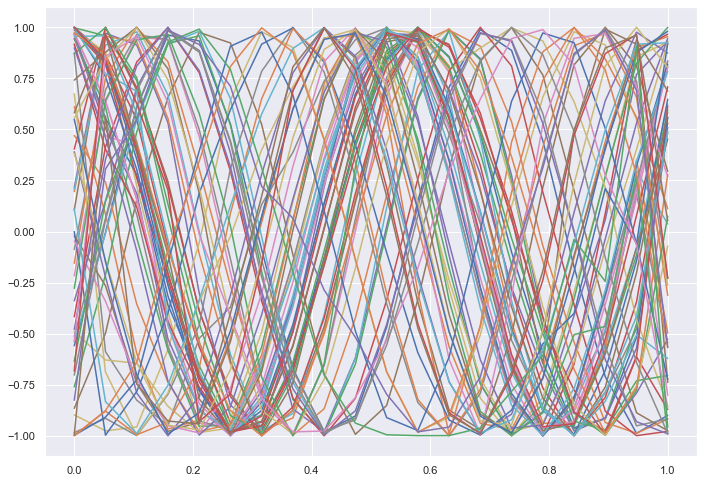

In [86]:
analytic_signal = hilbert(FilteredSignals,axis=0)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
t=np.linspace(0,1,20)
for i in range(0,N):
    ax = sns.lineplot(t,np.sin(instantaneous_phase[:,i]))
instantaneous_phase_no_mod = KFB.RemoveBounds(instantaneous_phase)

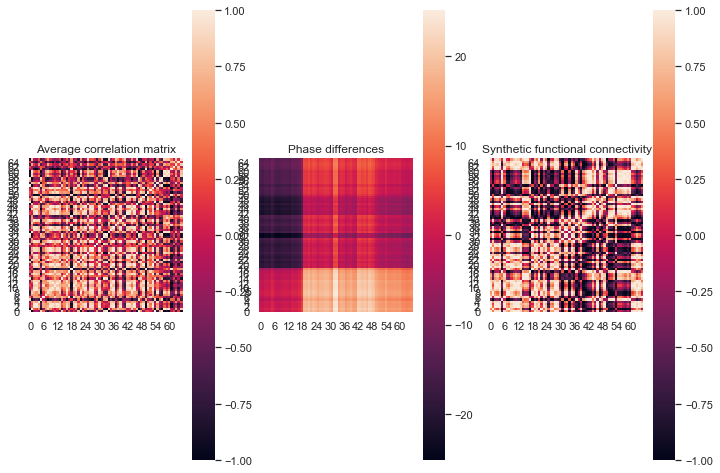

In [87]:
Cos_Phase_Differences = np.zeros((N,N,20))
Phase_Differences = np.zeros((N,N,20))
for i in range(0,20):
    for j in range(0,N):
        for k in range(0,N):
            Cos_Phase_Differences[j][k][i] = np.cos(instantaneous_phase[i][k]-instantaneous_phase[i][j])
            Phase_Differences[j][k][i] = instantaneous_phase[i][k]-instantaneous_phase[i][j]
Average_Cos_Phase_Difference = np.mean(Cos_Phase_Differences,axis=2)
Average_Phase_Difference = np.mean(Phase_Differences,axis=2)
C = KFB.CalculateCFromMeanPhaseDiff(Average_Phase_Difference)
EstimatedPhases = GPM.GPMAlgorithm(C)
x_min_brain = KFB.CalculateXMinFromPhases(EstimatedPhases)
SyntheticFC = KFB.CalculateCorrelationMatrix(x_min_brain)
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, (ax1, ax2,ax3) = plt.subplots(1,3)
ax1= sns.heatmap(Average_Cos_Phase_Difference.T,ax=ax1,square=True,vmin=-1,vmax=1)
ax1.invert_yaxis()
ax2= sns.heatmap(Average_Phase_Difference.T,ax=ax2,square=True)
ax2.invert_yaxis()
ax3= sns.heatmap(SyntheticFC.T,ax=ax3,square=True,vmin=-1,vmax=1)
ax3.invert_yaxis()
ax1.title.set_text('Average correlation matrix')
ax2.title.set_text('Phase differences')
ax3.title.set_text('Synthetic functional connectivity')
plt.show()

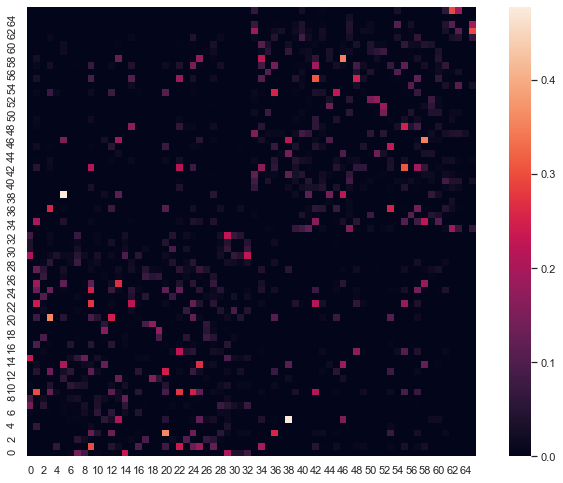

In [88]:
SC_DF = pd.read_csv('StructuralConnectivity.csv',header=None)
SCMatrix = np.array(SC_DF)
#Remove Diagonals
SC = SCMatrix
SC = SC - np.diagflat(np.diag(SC))
SC = (SC+SC.T)/2
ax = sns.heatmap(SC.T,square=True)
ax.invert_yaxis()
#Calculate quantities from inital parameters 
edges = KFB.CalculateEdgeSet(SC)
x_desired = KFB.CalculatePhaseDifferencesFromMin(x_min_brain,edges)
D = KFB.CalculateSinMatrix(edges,x_desired)
B = KFB.CalculateIncidenceMatrix(edges,N)
B_D = np.matmul(B,D)
delta1 = KFB.CalculateDeltaFromAdj(SC,edges)

w=B_D@delta1

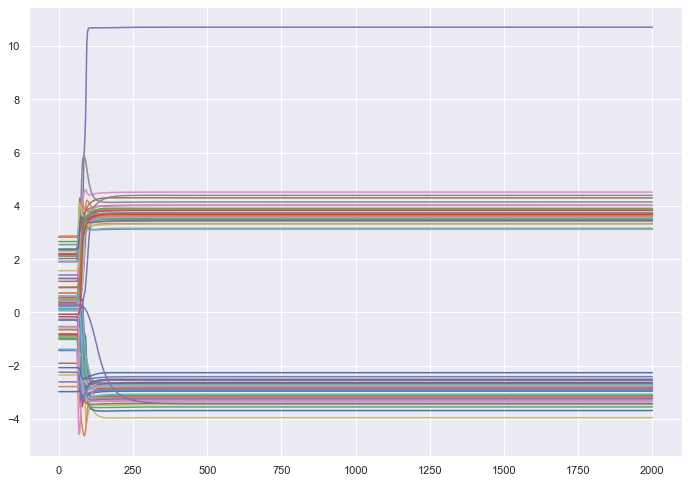

In [89]:
#Calculate quantities from inital parameters 
edges = KFB.CalculateEdgeSet(SC)
x_desired = KFB.CalculatePhaseDifferencesFromMin(x_min_brain,edges)
D = KFB.CalculateSinMatrix(edges,x_desired)
B = KFB.CalculateIncidenceMatrix(edges,N)
B_D = np.matmul(B,D)
delta1 = KFB.CalculateDeltaFromAdj(SC,edges)
w=B_D@delta1

#Solving the model with these params
theta_0 = EstimatedPhases
T=2000
num_points = 1000

sol,t = KFB.SolveKuramotoModel(theta_0,T,N,w,SC,num_points)

#Plot oscillator trajcetories
for i in range(0,N):
    ax = sns.lineplot(x=t,y=sol[:,i])

rho = np.zeros((N,N))
for i in range(0,N):
    for j in range(i+1,N):
        rho[i,j]=np.mean(np.cos(sol[:,j]-sol[:,i]))
rho = rho + rho.T + np.identity(N)

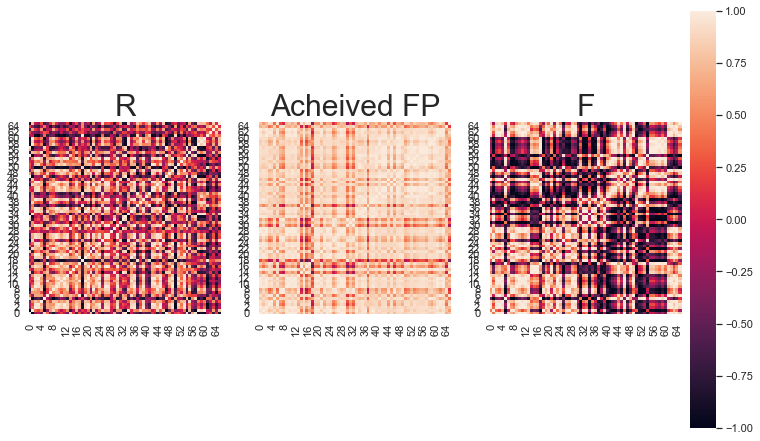

In [91]:
#Plot the acheived functional pattern to compare to the desired functional pattern
x_acheived = KFB.CalculatePhaseDiffs(sol[num_points-1,:])
Rho_desired = KFB.CalculateCorrelationMatrix(x_min_brain)

sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.title.set_text('R')
ax1.title.set_size(30)
ax2.title.set_text('Acheived FP')
ax2.title.set_size(30)
ax3.title.set_text('F')
ax3.title.set_size(30)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
sns.heatmap(Average_Cos_Phase_Difference.T, ax=ax1,square=True,cbar_ax=cbar_ax,vmin=-1,vmax=1)
sns.heatmap(rho.T, ax=ax2,square = True,cbar_ax=cbar_ax,vmin=-1,vmax=1)
sns.heatmap(SyntheticFC.T, ax=ax3,square=True,cbar_ax=cbar_ax,vmin=-1,vmax=1)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
plt.show()

In [93]:
# Construct the problem and solve the convex optimisation problem
delta = cp.Variable((len(edges),1))
beta = cp.Variable((N,1))
objective = cp.Minimize(cp.sum_squares(delta-delta1)+ cp.sum_squares(beta))
constraints = [B_D@delta==w+beta,delta >=0]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#Reobtain adjacency from delta vector and update frequencies
A = KFB.CalculateAdjFromDelta(delta.value,edges,N)
delta = delta.value
w = w+beta.value

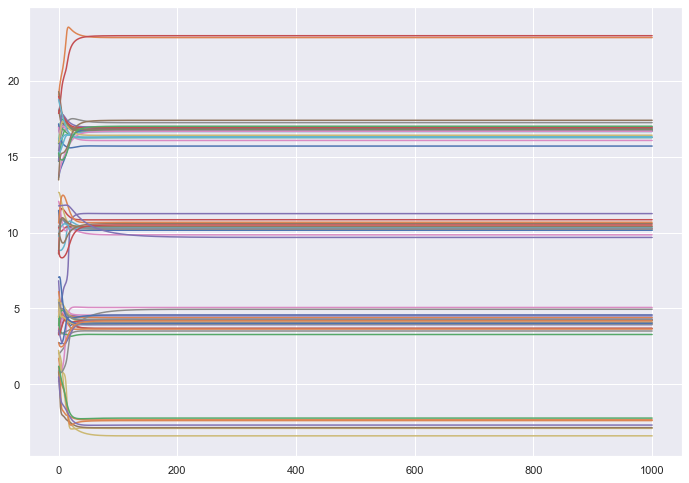

In [100]:
#Solving the model with these params
theta_0 = 20*np.random.rand(N)
T=1000
num_points = 1000

sol,t = KFB.SolveKuramotoModel(theta_0,T,N,w,A,num_points)

#Plot oscillator trajcetories
for i in range(0,N):
    ax = sns.lineplot(x=t,y=sol[:,i])

rho = np.zeros((N,N))
for i in range(0,N):
    for j in range(i+1,N):
        rho[i,j]=np.mean(np.cos(sol[:,j]-sol[:,i]))
rho = rho + rho.T + np.identity(N)

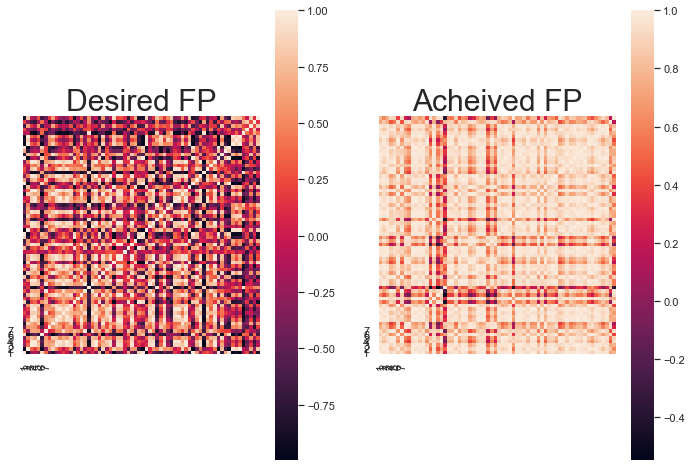

In [101]:
#Plot the acheived functional pattern to compare to the desired functional pattern
x_acheived = KFB.CalculatePhaseDiffs(sol[num_points-1,:])
Rho_acheived = KFB.CalculateCorrelationMatrix(x_acheived)
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.title.set_text('Desired FP')
ax1.title.set_size(30)
ax2.title.set_text('Acheived FP')
ax2.title.set_size(30)
sns.heatmap(Average_Cos_Phase_Difference.T, ax=ax1,square=True,xticklabels='1234567',yticklabels='1234567')
sns.heatmap(rho.T, ax=ax2,square = True,xticklabels='1234567',yticklabels='1234567')
ax1.invert_yaxis()
ax2.invert_yaxis()
plt.show()
